# Abdominal-Trauma-Detection
##  Multi-Label Classification Problem

The goal of this competition is to identify several potential injuries in CT scans of trauma patients. Any of these injuries can be fatal on a short time frame if untreated so there is great value in rapid diagnosis.

# Getting a Dataset

In [6]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt


DATA_PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection/'

train_csv = pd.read_csv(f'{DATA_PATH}/train_2024.csv')
train_csv = train_csv.set_index('patient_id')



image_level_labels = pd.read_csv(f'{DATA_PATH}/image_level_labels_2024.csv')


In [7]:
train_csv.head()

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
patient_id,,,,,,,,,,,,,,
10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [8]:
print(len(train_csv),'patint')

3147 patint


In [36]:
class_names =list(train_csv.columns)
class_names

['bowel_healthy',
 'bowel_injury',
 'extravasation_healthy',
 'extravasation_injury',
 'kidney_healthy',
 'kidney_low',
 'kidney_high',
 'liver_healthy',
 'liver_low',
 'liver_high',
 'spleen_healthy',
 'spleen_low',
 'spleen_high',
 'any_injury']

# Visualize Data

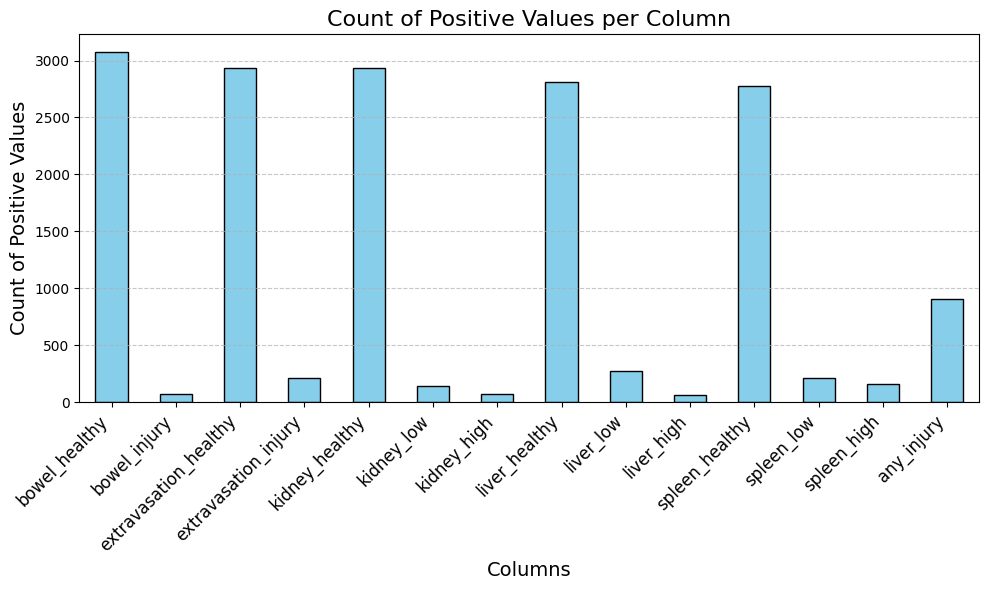

In [3]:
# Count positive values (1) for each column
positive_counts = train_csv.sum()

# Visualization
plt.figure(figsize=(10, 6))
positive_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Positive Values per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count of Positive Values', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## imblanced dataset !!

In [18]:
image_level_labels

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
...,...,...,...,...
15627,9632,3750,155,Active_Extravasation
15628,9632,3750,156,Active_Extravasation
15629,9632,3750,157,Active_Extravasation
15630,9632,3750,158,Active_Extravasation


In [25]:
print(f"{len(image_level_labels)} image for {len(train_csv)} patint")

15632 image for 3147 patint


### * 15632 image for 3147 patint

In [20]:
len(image_level_labels[image_level_labels['patient_id'] == 9632])

22

## load images from resized dataset from 400GB to ~7.5GB
by Resized the DCM images from 512x512 to 256x256
Reduced the slice tickness to only 5 millimeters, skipping the intermediate scans (slice tickness range from 0.5 to 5mm)
Encoded and standardized the DCM images to JPEG

In [146]:
train_256_jpgs = glob.glob('/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/*/*/*.jpeg')
np.random.shuffle(train_256_jpgs)

In [11]:
train_256_jpgs

['/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/59817/36297/113.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/3283/8630/160.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/16588/45575/133.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/28724/55735/49.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/23369/61441/178.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/45164/20063/200.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/40406/60539/277.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/26045/20852/773.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/6879/21521/542.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/10494/65369/456.jpeg',
 '/kaggle/input/rsna-2023-atd-reduced-256-5mm/reduced_256_tickness_5/6083/30630/317.

In [12]:
pids = list(train_csv.index)

In [13]:
len(pids)

3147

In [23]:
labels = train_csv.values[:]
labels[0]

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1])

# Data Loading and Transformation,
## + Augmentation -->(if image belongs to the minority category_ ))

In [24]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torch
import pandas as pd


# Augmentation transforms for images requiring augmentation
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),  # Randomly rotate images within 15 degrees
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Basic transforms for other images
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Dataset Definition
class RSNADataset(Dataset):
    def __init__(self, img_paths, csv_data, transform_augment, transform_basic):
        self.img_paths = img_paths
        self.csv_data = csv_data
        self.transform_augment = transform_augment
        self.transform_basic = transform_basic

    def __getitem__(self, index):
        # Get image path and patient ID
        img_path = self.img_paths[index]
        pid = int(img_path.split('/')[-3])  # Adjust based on your file structure
        
        # Load image
        img = Image.open(img_path)

        # Get labels for the patient ID
        labels = self.csv_data.loc[pid].values[:]
        
        # Check if image needs augmentation
        #0,2,4,7,10 
        if labels[0] == 1 or labels[2] == 1 or labels[4] == 1 or labels[7] == 1 or labels[10] == 1:  # Specific labels: extravasation_healthy, kidney_healthy, liver_healthy
            img = self.transform_basic(img)
        else:
            img = self.transform_augment(img)

        return img, torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.img_paths)


# Split patient IDs
split_train = -400  # Adjust these based on dataset size
split_val = -200

#  `train_256_jpgs` contains paths to all images
train_imgs = [x for x in train_256_jpgs if int(x.split('/')[-3]) in pids[:split_train]]
val_imgs = [x for x in train_256_jpgs if int(x.split('/')[-3]) in pids[split_train:split_val]]
test_imgs = [x for x in train_256_jpgs if int(x.split('/')[-3]) in pids[split_val:]]

# Instantiate Dataset and DataLoaders
train_dataset = RSNADataset(train_imgs, train_csv, augment_transform, basic_transform)
val_dataset = RSNADataset(val_imgs, train_csv, augment_transform, basic_transform)
test_dataset = RSNADataset(test_imgs, train_csv, augment_transform, basic_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [25]:
print(len(train_loader))

13268


In [26]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images[0],labels[0])

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]) tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.])


# display_random_images

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(loader, num_images=5):
    """
    Display random images from a DataLoader.
    
    Args:
        loader (DataLoader): The DataLoader object.
        num_images (int): Number of images to display.
    """
    # Get a batch of images and labels from the loader
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Convert images to NumPy format for visualization
    images = images.numpy()
    labels = labels.numpy()
    
    # Select random indices from the batch
    indices = np.random.choice(len(images), size=num_images, replace=False)
    
    # Plot the images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = images[idx].transpose(1, 2, 0)  # Convert CHW to HWC format
        label = labels[idx]
        
        # Normalize the image to display properly (if normalized in transformations)
        img = (img * 0.5) + 0.5  # Undo normalization if mean=0.5, std=0.5
        img = np.clip(img, 0, 1)  # Ensure values are within [0, 1]
        
        axs[i].imshow(img)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


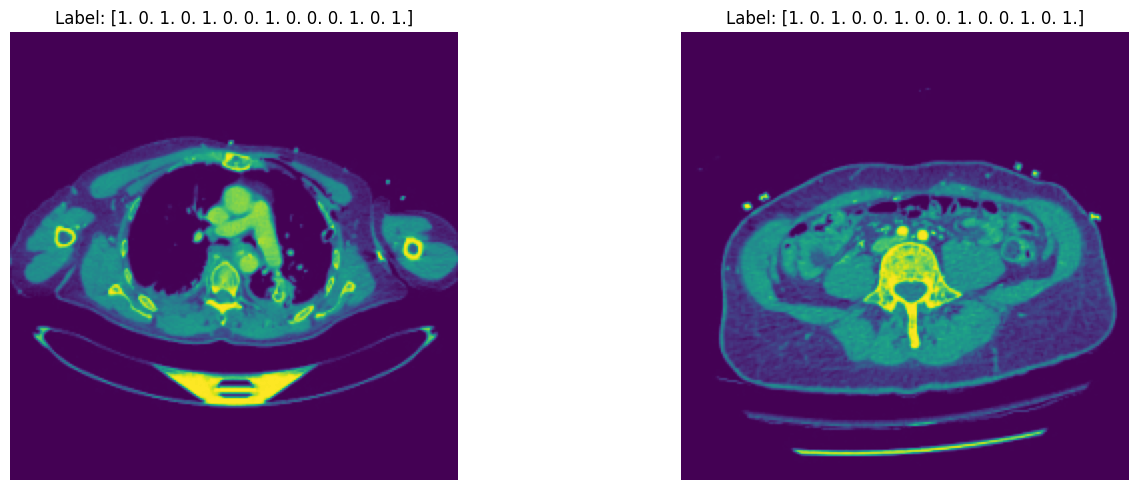

In [28]:
display_random_images(train_loader, num_images=2)

# build model with efficientnet_b0

The sample weights are as follows:
* 
1 for all healthy labels* .
2 for low grade solid organ injuries (liver, spleen, kidney* ).
4 for high grade solid organ injuri* es.
2 for bowel injur* ies.
6 for extravasa* tion.
6 for the auto-generated any_injury label. label.

In [41]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load EfficientNet (pretrained)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the first convolution layer for single-channel input
model.features[0][0] = nn.Conv2d(
    in_channels=1,  # Change input channels to 1 (grayscale)
    out_channels=32,
    kernel_size=(3, 3),
    stride=(2, 2),
    padding=(1, 1),
    bias=False
)

# Modify the classifier for the required number of output classes
num_classes = 14  # Change this to your required number of output classes
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

# Move the model to GPU
model = nn.DataParallel(model, device_ids=[0, 1])  # Use GPUs 0 and 1
model = model.cuda()



# Define the loss function with class weights
pos_weight = torch.Tensor([1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4, 6]).cuda() 
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)




In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# # Load EfficientNet (pretrained)
# model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# # Modify the first convolution layer for single-channel input (grayscale)
# model.features[0][0] = nn.Conv2d(
#     in_channels=1,  # Change input channels to 1 (grayscale)
#     out_channels=32,
#     kernel_size=(3, 3),
#     stride=(2, 2),
#     padding=(1, 1),
#     bias=False
# )

# # Modify the classifier for the required number of output classes
# num_classes = 14  # Change this to your required number of output classes
# model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

# # Move the model to GPU
# model = model.cuda()



# # # freezing the first layer.
# # for param in model.features[0].parameters():
# #     param.requires_grad = False  
# # for param in model.features[1:].parameters():
# #     param.requires_grad = True   # Train all subsequent layers

# # Define the loss function with class weights
# pos_weight = torch.Tensor([1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4, 6]).cuda()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Define the optimizer - only the parameters of the classifier are trained
# optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.0005)

# # If you want to train the entire model, use the following optimizer:
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)


In [30]:
from torchinfo import summary
summary(model=model, 
        input_size=(32, 1, 224, 224), 
        col_names=["input_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 1, 224, 224]    --                   True
├─Sequential (features)                                      [32, 1, 224, 224]    --                   True
│    └─Conv2dNormActivation (0)                              [32, 1, 224, 224]    --                   True
│    │    └─Conv2d (0)                                       [32, 1, 224, 224]    288                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   --                   True
│    │    └─MBConv (0)                                       [32, 32, 112, 112]   1,448                True
│    └─Sequential (2)    

# Traning Loop

In [42]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize storage for losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Training Step
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    
    for images, labels in train_loader_tqdm:
        images, labels = images.cuda(), labels.cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute predictions and accuracy
        predictions = torch.sigmoid(outputs) > 0.5  # For binary/multilabel classification
        correct_train += (predictions == labels).sum().item()
        total_train += labels.numel()  # Total number of elements in labels

        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=(correct_train / total_train) * 100)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    
    # Validation Step
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Compute predictions and accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            correct_val += (predictions == labels).sum().item()
            total_val += labels.numel()

            val_loader_tqdm.set_postfix(loss=loss.item(), accuracy=(correct_val / total_val) * 100)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


Epoch [1/5]


Training:   0%|          | 0/13268 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Training Loss: 0.5192, Accuracy: 87.80%


Validation Loss: 0.4664, Accuracy: 88.98%
Epoch [2/5]


Training Loss: 0.4585, Accuracy: 89.04%


Validation Loss: 0.4628, Accuracy: 88.98%
Epoch [3/5]


Training Loss: 0.4530, Accuracy: 89.05%


Validation Loss: 0.4615, Accuracy: 88.97%
Epoch [4/5]


Training Loss: 0.4486, Accuracy: 89.10%


Validation Loss: 0.4612, Accuracy: 88.93%
Epoch [5/5]


Training Loss: 0.4443, Accuracy: 89.21%


Validation Loss: 0.4595, Accuracy: 89.05%


In [32]:
total_loss

2112.391881674528

# Visualizing Loss Function

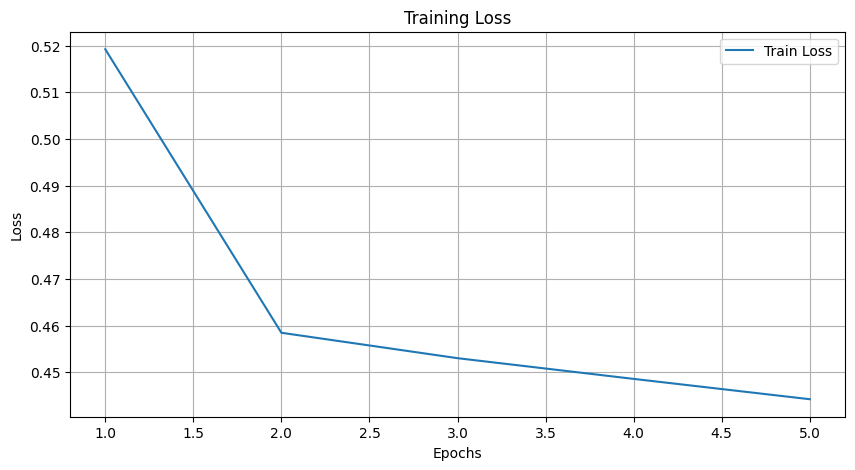

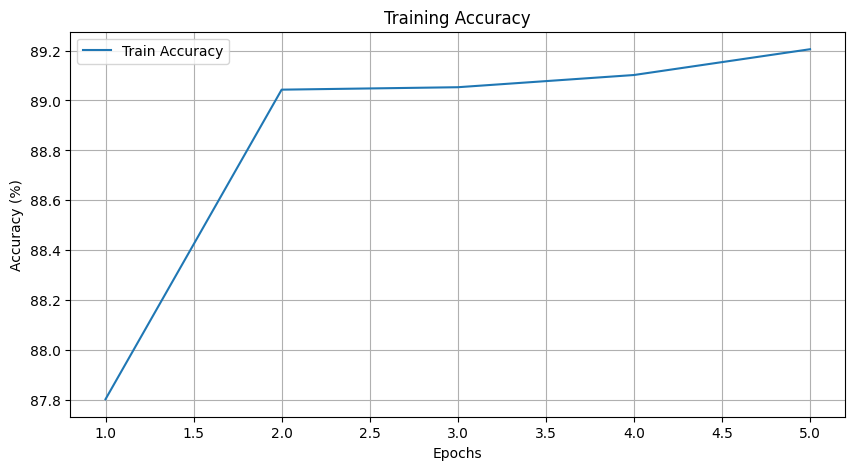

In [44]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid()
plt.show()


# Evaluate Model with Test Set

In [126]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    # Concatenate predictions and labels across all batches
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()

    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())

    f1 = f1_score(all_labels, all_preds, average='weighted')

    recall = recall_score(all_labels, all_preds, average='weighted')

    precision = precision_score(all_labels, all_preds, average='weighted')

    # Print general metrics
    print(f" Accuracy: {accuracy:.4f}")
    print(f" F1 Score (Weighted): {f1:.4f}")
    print(f" Recall (Weighted): {recall:.4f}")
    print(f" Precision (Weighted): {precision:.4f}")


In [127]:
evaluate_model(model, test_loader)

 Accuracy: 0.9021
 F1 Score (Weighted): 0.8785
 Recall (Weighted): 0.9368
 Precision (Weighted): 0.8570


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction and Visualization

In [107]:
def make_predictions_and_visualize(model, loader, num_samples=2):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds = probs > 0.5  # Binary predictions

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                # Prepare true labels and predicted labels with confidence
                true_labels = [class_names[j] for j, val in enumerate(labels[i].cpu().numpy()) if val == 1]
                pred_labels_with_conf = [
                    f"{class_names[j]} ({probs[i][j].item():.2f})" 
                    for j, val in enumerate(preds[i].cpu().numpy()) if val == 1
                ]

                # Show image
                if images[i].size(0) == 1:  # Grayscale
                    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
                else:  # RGB
                    plt.imshow(images[i].permute(1, 2, 0).cpu())
                
                # Display true and predicted labels with confidence
                plt.title(f"True: {true_labels}\nPredicted: {pred_labels_with_conf}")
                plt.axis('off')
                plt.show()
                samples_shown += 1


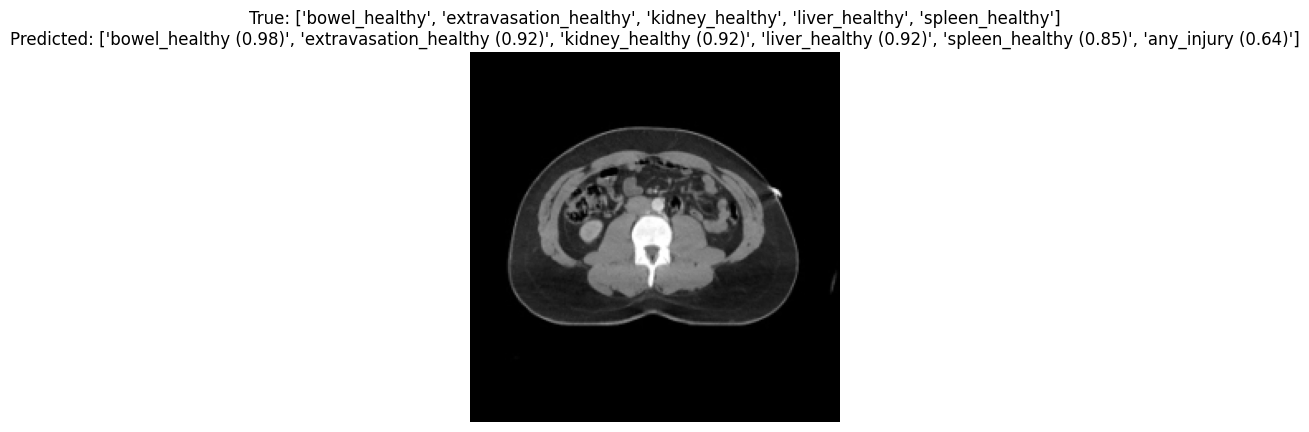

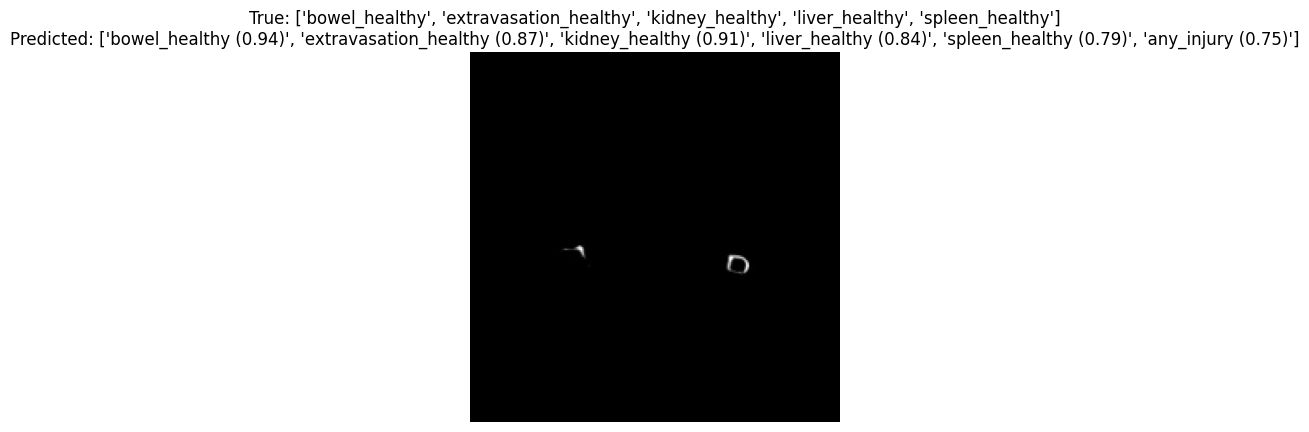

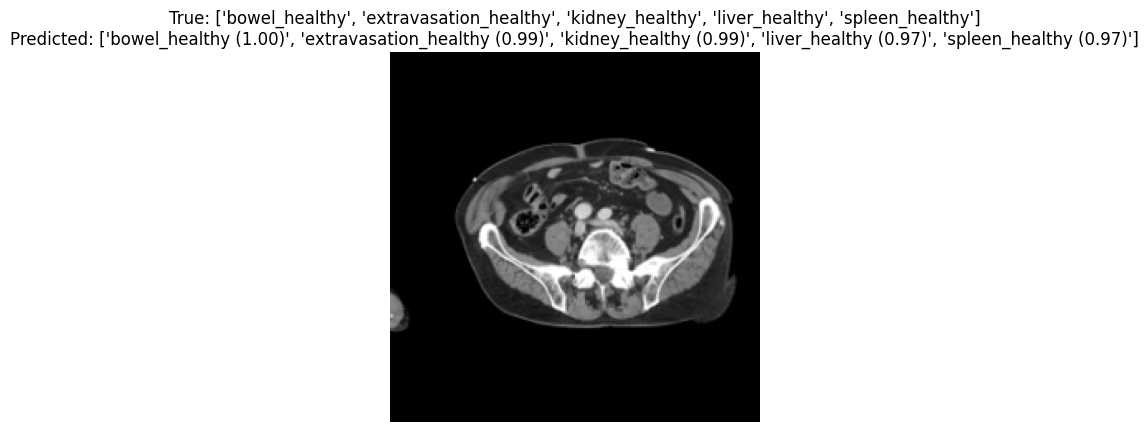

In [118]:
make_predictions_and_visualize(model, val_loader, num_samples=3)

# Saving the Model

In [47]:
torch.save(model.state_dict(), "efficientnet_b0_Abdominal_TraumaDetection.pth")
print("Model saved successfully!")


Model saved successfully!


In [125]:
torch.save(model, "Abdominal_TraumaDetection_all_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
torch.save(model.state_dict(), "efficientnet_b0_Abdominal_TraumaDetection.pth")
print("Model saved successfully!")


In [136]:
import torch

# Path to save the model
save_path = "model.pth"

# Save the entire model
torch.save(model, save_path)
print(f"Model saved to {save_path}")


Model saved to model.pth


# Load the Model

In [138]:
# Initialize the single-GPU model
model_saved = models.efficientnet_b0(weights=None)  # Same architecture
model_saved.features[0][0] = nn.Conv2d(
    in_channels=1, 
    out_channels=32, 
    kernel_size=(3, 3), 
    stride=(2, 2), 
    padding=(1, 1), 
    bias=False
)
model_saved.classifier[1] = nn.Linear(in_features=model_saved.classifier[1].in_features, out_features=14)

# Load the state dictionary and strip the `module.` prefix
state_dict = torch.load("efficientnet_b0_Abdominal_Trauma_Detection.pth")
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}  # Remove prefix
model_saved.load_state_dict(new_state_dict)

# Set model to evaluation mode for inference
model_saved.eval()
print("Model loaded and ready for single-GPU inference.")


/tmp/ipykernel_23/4265225801.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("efficientnet_b0_Abdominal_Trauma_Detection.pth")


Model loaded and ready for single-GPU inference.
